# Etiquetado de empresas zombis
En este cuaderno se trata la problemática del etiquetado de las empresas zombis. Este proceso tiene en cuenta varias fuentes de datos:

1. Resultado de los ejercicios 2017-2019. Provienen del cuaderno de análisis, limpieza y transformación de los ejercicios fiscales de las empresas. Esta se encuentra mínimamente procesada y solo tiene el propósito de etiquetar las empresas como zombis o no.
2. Datos básicos de la empresa: proviene del cuaderno de los datos básicos de empresa. Incluye información sobre el tipo de empresa, los empleados, la ruralidad...
3. Resultados agregados de los ejercicios. Representa los principales indicadores fiscales y su evolución a través de los ejercicios.

En primer paso, se deben etiquetar los datos según los dos criterios principales y decidir cuál resulta más indicado, dadas las circunstancias. Los criterios que se pueden utilizar con los datos disponibles son:

* Criterio OECD: Empresas con más de 10 años de antigüedad y con un ratio de cobertura de interés (RA/RAGXFI) inferior a 1 durante 3 ejercicios consecutivos.
* Criterio zombi extremo: Empresas con equidad negativa (Pasivo menos activo negativo) en el último ejercicio fiscal.

Para el criterio de la OECD, se elimina la restricción de la antigüedad, ya que son muchas las empresas que se pueden librar de ser etiquetadas mediante esta restricción en Colombia. El país se encuentra en crecimiento emergente, y tiene muchas empresas fundadas en las décadas de los 2000/2010. Resulta más ideal prescindir de la condición de antigüedad, ya que muchas de las empresas quedaban fuera de la definición.

El primer paso consta de la lectura de los datasets y la etiquetación de las empresas según los dos criterios.

In [39]:
# Importes necesarios
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import power_transform
import matplotlib.gridspec as gridspec
import math
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

In [2]:
# Leer los ejercicios
ejercicios = pd.read_csv('data/EjerciciosClean.csv', sep=";")
basicos = pd.read_csv('data/DatosEmpresaClean.csv', sep=";")

# Etiqutar las empresas
def etiquetarZombi(group):
    row = dict()
    isZombi = True
    isZombiExtremo = True
    empresaId = group['ID'].unique()[0]
    
    if (len(basicos[basicos['Id'] == empresaId]) == 0):
        return None
    else:
        if (False and basicos[basicos['Id'] == empresaId]['AnyoConstitucion'].iloc[0] > 2009):
            isZombi = False
        else:
            for year in [2017,2018,2019]:
                ragxfiCell = group.loc[group['Anyo'] == year,'RAGXFI']
                yearCell =  group.loc[group['Anyo'] == year,'RA']
                if (len(ragxfiCell) == 0 or len(yearCell) == 0):
                    return None
                ragxfi = ragxfiCell.iloc[0]
                if (ragxfi > 0):
                    ratio = yearCell.iloc[0] / ragxfi
                    if (ratio >= 1):
                        isZombi = False
                else:
                    isZombi = False
            
        numEmplLog = basicos[basicos['Id'] == empresaId]['NumEmpleadosLog'].iloc[0]
        if (False):
            isZombiExtremo = False
        else:
            for year in [2019]:
                PasivoCell = group.loc[group['Anyo'] == year,'PS']
                ActivoCell = group.loc[group['Anyo'] == year,'AC']
                if (len(PasivoCell) == 0 or len(ActivoCell) == 0):
                    return None
                
                if (ActivoCell.iloc[0] >= PasivoCell.iloc[0]):
                    isZombiExtremo = False
                    
    row['isZombiExtremo'] = isZombiExtremo
    row['isZombiOECD'] = isZombi
    row['ID'] = empresaId
    
    return pd.Series(row)
 
# Crear los grupos y etiquetar las empresas
empresasZombis = ejercicios.groupby('ID').apply(etiquetarZombi)
empresasZombis = empresasZombis.reset_index(drop=True)
empresasZombis.head()

,isZombiExtremo,isZombiOECD,ID
0,False,False,233151.0
1,False,False,233207.0
2,False,False,233235.0
3,False,False,233284.0
4,False,False,233291.0


Una vez se han etiquetado las empresas según los dos criterios, se debe decidir cual es el más adecuado para convertirse en la variable objetiva o dependiente.

En primer lugar, se realiza la operación de join con los ejercicios agregados, lo que significa que muchas empresas quedarán fuera del etiquetado (debido a los procesos de limpieza de datos fiscales, que han eliminado un porcentaje significativo de las empresas detectadas como outliers).

In [7]:
# Leer los ejercicios agregados
ejerciciosAgregados = pd.read_csv('data/EjerciciosAgregados.csv', sep=";")
# Operacion Merge
empresasZombisAgregadas = ejerciciosAgregados.drop_duplicates('ID').set_index('ID').join(empresasZombis.set_index('ID'),on="ID",how="inner")

# Imprime el número de empresas zombis en un conjunto
def printZombiCounts(df, column, title):   
    notZombis = df[column].value_counts()[0]
    areZombis = df[column].value_counts()[1] if len(df[column].value_counts()) > 1 else 0
    prop = areZombis/(areZombis+notZombis)

    print("{0}: Empresas no zombis: {1}, Empresas zombis: {2}, proporción: {3:.0%}"\
      .format(title, notZombis, areZombis, prop))

printZombiCounts(empresasZombisAgregadas, 'isZombiOECD','OECD')
printZombiCounts(empresasZombisAgregadas, 'isZombiExtremo','Zombi extremo')

empresasZombisAgregadas.head()

OECD: Empresas no zombis: 11383, Empresas zombis: 1621, proporción: 12%
Zombi extremo: Empresas no zombis: 12750, Empresas zombis: 254, proporción: 2%


,ACC,ACL,PSC,PSL,PTT131,RAIE,VAR_REL_AC,VAR_REL_ACC,VAR_REL_ACL,VAR_REL_PS,...,RelPasivoCortoProvisiones_CAT,RelPasivoCortoOtros_CAT,RelPasivoLargoImpuestos_CAT,RelPasivoLargoOtros_CAT,PTT237_CAT,PTT133_CAT,VAR_REL_RAGE60_CAT,ConcentracionCorto_CAT,isZombiExtremo,isZombiOECD
ID,,,,,,,,,,,,,,,,,,,,,
233151,6.832653,6.919862,6.637769,6.469731,6.521733,7.026720,0.227132,-0.010132,0.526444,0.397214,...,1,1,1,3,3,1,1.0,2,False,False
233207,6.590472,6.610549,5.970130,5.990584,6.079182,6.942706,-0.008906,0.150429,-0.124664,-0.138152,...,1,1,0,3,0,1,3.0,2,False,False
233235,6.363655,6.991423,5.609876,5.550863,6.548141,6.061158,-0.014317,-0.279858,0.079473,-0.437588,...,0,0,3,0,2,0,2.0,2,False,False
233284,7.640497,7.555169,7.534655,6.533034,6.090787,8.032983,0.099791,-0.067320,0.406515,0.075601,...,1,1,3,0,4,4,1.0,3,False,False
233291,7.284296,7.574131,7.147853,7.084156,5.764924,7.713238,0.131963,0.233249,0.086194,0.340153,...,1,1,2,2,4,3,3.0,2,False,False


La proporción de empresas zombi según el criterio de la OECD encaja con las estimaciones de estudios anteriores (alrededor del 10-15%). Pero la proporción de zombis extremos es muy baja.

Los zombis extremos son aquellos con patrimonio negativo, y como se ha visto anteriormente, son poco representativos en el dataset.

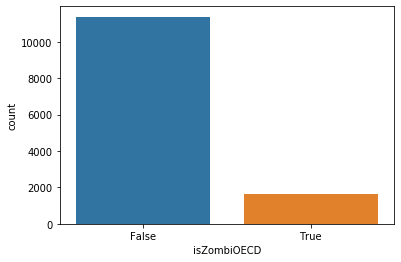

In [8]:
# Observar el diagrama de conteo de la variable zombi según la OECD
sns.countplot(data=empresasZombisAgregadas,x='isZombiOECD')
plt.show()

Para conocer cuál etiqueta es más representativa, se realiza un test de comparación de medias no paramétrico (Kruskal) respecto a los grupos zombis/no zombis. La hipótesis nula de este test es que las dos muestras provienen de la misma población. Las variables que rechazan la hipótesis nula de no independencia tendrán más relación con la etiqueta zombi proporcionada, ya que existirá una diferencia entre sus distribuciones.

En primer lugar se realiza el test para los zombis según la OECD y luego para los zombis extremos.

No han rechazado la hipótesis nula: ['RelPasivoCortoPagar' 'VAR_ABS_RelPasivoCortoPagar'
 'VAR_ABS_RelActivoCortoEfectivo' 'VAR_REL_PS' 'VAR_REL_PSC']


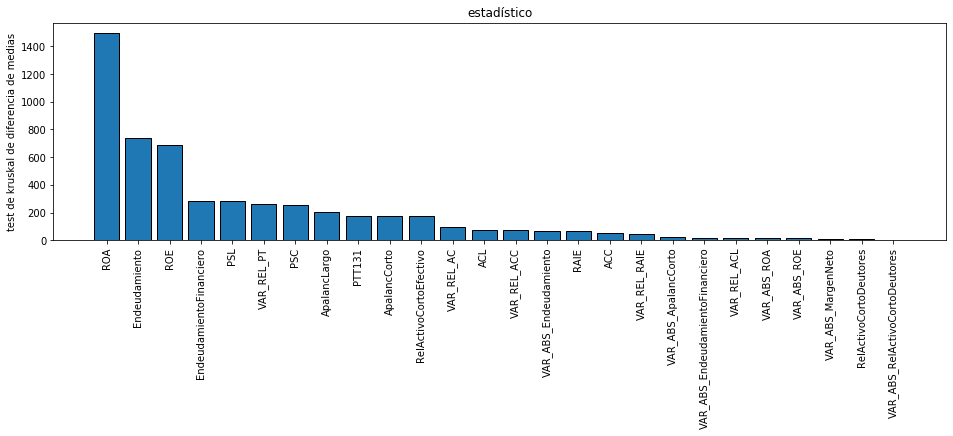

In [9]:
def individual_kruskal_test(df, column, target):
    yesZombis = df[(df[target] == True) & (df[column].notna())][column]
    noZombis = df[(df[target] == False) & (df[column].notna())][column]
    if ((yesZombis == 0).all() and (noZombis == 0).all()):
        print("La variable: {0} tiene todos sus valores a 0".format(column))
        return {'stat':0,'p-value':2,'column':column}
    if (len(yesZombis) == 0):
        print("La variable: {0} no tiene zombis".format(column))
        return {'stat':0,'p-value':2,'column':column}
    if (len(noZombis) == 0):
        print("La variable: {0} no tiene empresas no zombis".format(column))
        return {'stat':0,'p-value':2,'column':column}
    
    stat, p = stats.kruskal(yesZombis, noZombis)
    return {'stat':stat,'p-value':p,'column':column}

def perform_kruskal_test(df, columns, target_column):
    return [individual_kruskal_test(df, column, target_column) for column in columns]

def plotShowStatTest(df, ignoreColumns, target_column, test_func, title, ylabel):
    toRemove = ignoreColumns
    columns = [column for column in df.columns.values.tolist() \
               if column not in toRemove]

    plotShowStatTestColumns(df, columns, target_column, test_func, title, ylabel)

def plotShowStatTestColumns(df, columns, target_column, test_func, title, ylabel):
    df = pd.DataFrame(test_func(df, columns, target_column))

    df = df.sort_values('stat',ascending=False)
    df_not_rejected = df[df['p-value'] >= 0.05]
    df_rejected = df[df['p-value'] < 0.05]
    
    print("No han rechazado la hipótesis nula: {0}".format(df_not_rejected['column'].unique()
                                                          ))
    plt.figure(figsize=(16,4))
    plt.bar(df_rejected['column'],df_rejected['stat'],edgecolor='black')
    plt.xticks(rotation="vertical")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

categoricalVars = [v for v in empresasZombisAgregadas.columns.tolist() if v.endswith("_CAT")]
plotShowStatTest(empresasZombisAgregadas, ['ID','isZombiExtremo','isZombiOECD'] + categoricalVars, 'isZombiOECD', perform_kruskal_test, "estadístico", "test de kruskal de diferencia de medias")

El test de Kruskal requiere la asunción que las distribuciones entre grupos son similares, por lo que se inspecciona de manera visual la diferencia entre grupos en la distribución de las variables:

distribuciones entre grupos (OECD). Media por grupo en vertical: 


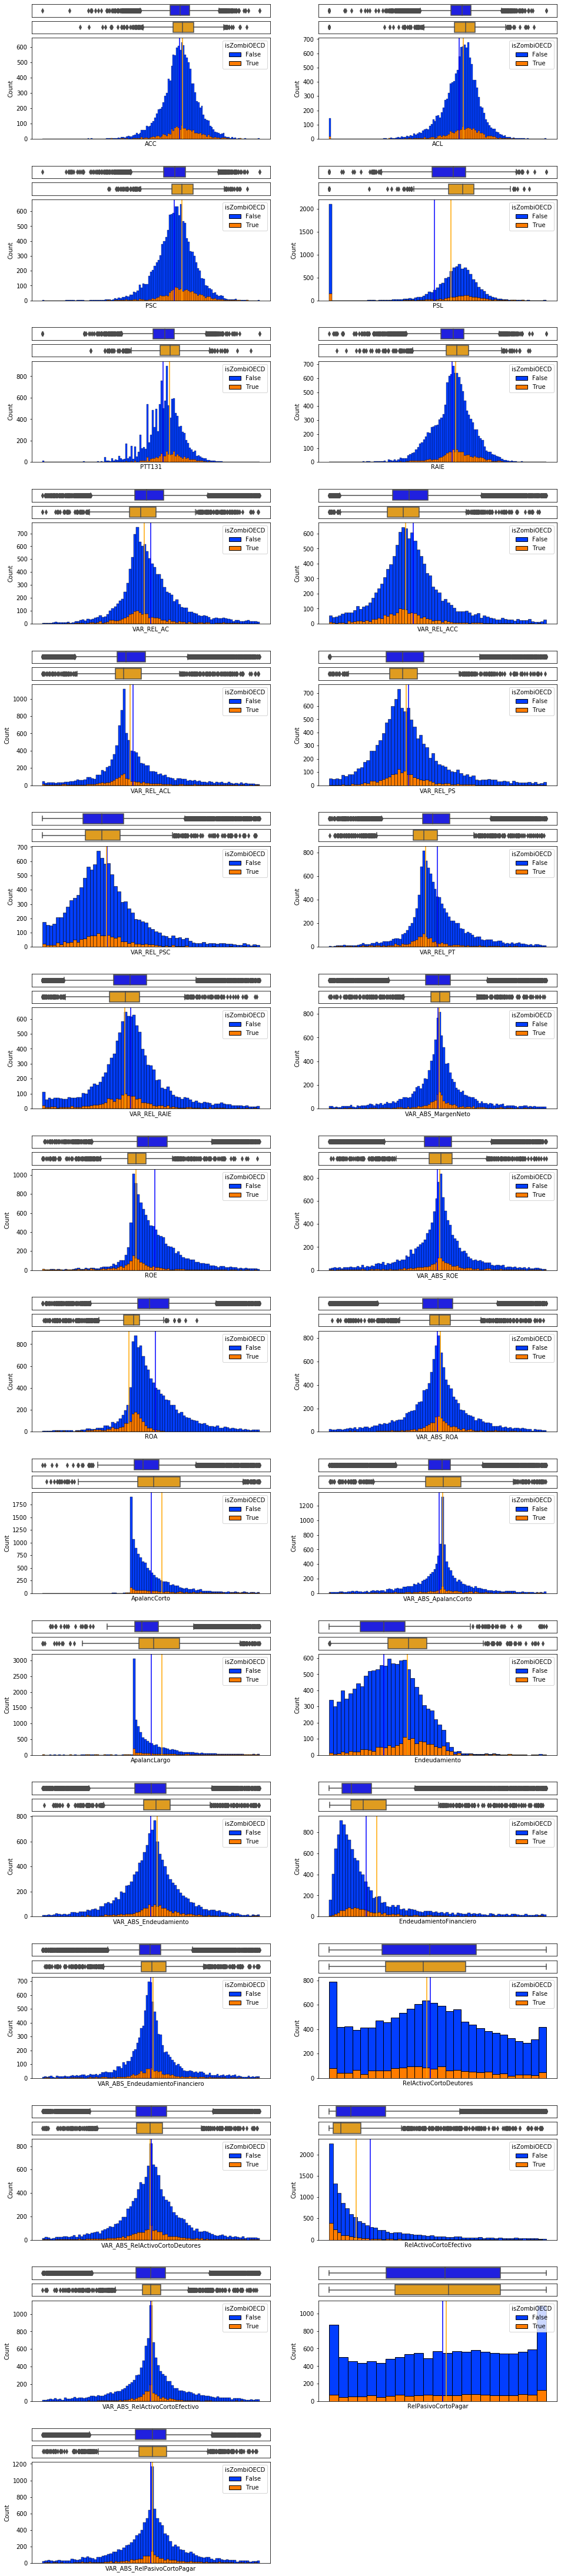

In [10]:
def plot_hist_test(df, column, target, inner, fig):
    ax_hist = plt.Subplot(fig, inner[2])
    ax_box1 = plt.Subplot(fig, inner[1], sharex=ax_hist)
    ax_box2 = plt.Subplot(fig, inner[0], sharex=ax_hist)
    
    # Add a graph in each part
    sns.boxplot(x=df[df[target]==1][column], ax=ax_box1,color='orange')
    sns.boxplot(x=df[df[target]==0][column], ax=ax_box2,color='blue')
    sns.histplot(data=df, x=column, hue=target, ax=ax_hist, palette=sns.color_palette("bright", 2), alpha=1,multiple="stack")
    meanNo = df[df[target] == False][column].mean()
    meanYes = df[df[target] ==True][column].mean()
    ax_hist.axvline(meanNo, color='blue', ls='-')
    ax_hist.axvline(meanYes,color='orange', ls='-')
    
    # Remove x axis name for the boxplot
    ax_box1.set(xlabel='')
    ax_box2.set(xlabel='')
    
    ax_box1.set(xticks=[], yticks=[])
    ax_box2.set(xticks=[], yticks=[])
    
    fig.add_subplot(ax_box1)
    fig.add_subplot(ax_box2)
    fig.add_subplot(ax_hist)

def plot_grid(df, columns, target):
    nRows = math.ceil(len(columns) / 2)
    nCols = 2
    
    figSize = nRows * 5
    fig = plt.figure(figsize=(16, figSize))
    outer = gridspec.GridSpec(nRows, nCols, wspace=0.2, hspace=0.2)
    
    for i,e in enumerate(columns):
        row = int(i/nCols)
        col = i % nCols
        inner = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer[i],wspace=0.1, hspace=0.1,height_ratios=[0.1,0.1,0.8])
        plot_hist_test(df, e, target, inner, fig)
        
    if (len(columns) < nCols * nRows):
        pass
        #axes[numRows-1,numCols-1].axis('off')

print("distribuciones entre grupos (OECD). Media por grupo en vertical: ")
plot_grid(empresasZombisAgregadas, [c for c in empresasZombisAgregadas.columns.values.tolist() if c not in ['isZombiExtremo','ID','isZombiOECD'] + categoricalVars],"isZombiOECD")

Se observa que:

1. El endeudamiento es quizá la variable con una diferencia más clara respecto a las dos distribuciones. Las dos distribuciones tienen una forma ligeramente distinta y su media está claramente desplazada.
2. La mayoría de variables financieras (ACC, ACL...) tienen distribuciones casi iguales entre los dos grupos. Sus medias son muy similares, pudiendo ser más amplia en algunas variables por la presencia de más ceros. Se recuerda que los ceros significan ratios o variables que no se han podido calcular por culpa de ser cero alguna de los operandos de origen, precisamente.
3. Todas las otras variables no tienen diferencias significativas en sus distribuciones, ni tampoco desplazamientos, por lo que, a priori, parece que las empresas zombis siguen la misma distribución con misma media y desviación que las empresas no zombis para la gran mayoría de variables, indicadores y relaciones.
4. Se deben ignorar las variables que presentan una alta relación con la definición como el ROE o el ROA.

A continuación se realiza el mismo ejercicio para las empresas zombis extremas:

No han rechazado la hipótesis nula: ['RelActivoCortoDeutores' 'PSL' 'VAR_ABS_ROE' 'ACC'
 'VAR_ABS_RelActivoCortoEfectivo' 'VAR_ABS_RelPasivoCortoPagar']


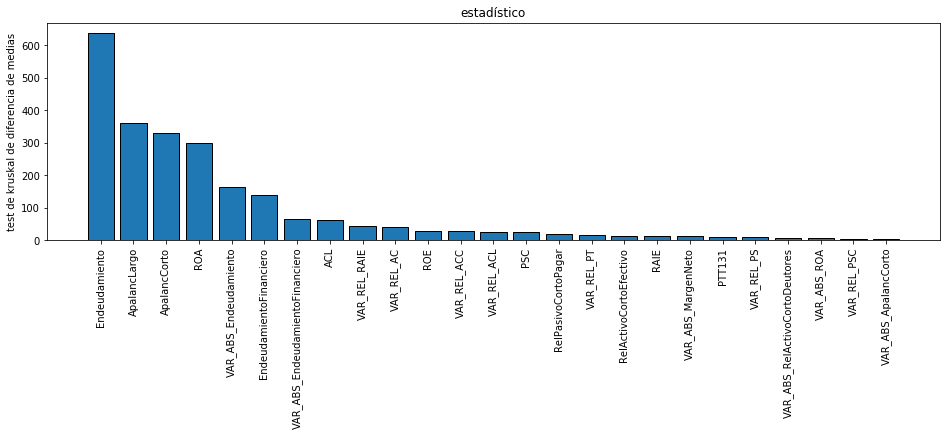

In [11]:
plotShowStatTest(empresasZombisAgregadas, ['ID','isZombiExtremo','isZombiOECD'] + categoricalVars, 'isZombiExtremo', perform_kruskal_test, "estadístico", "test de kruskal de diferencia de medias")

Esta vez son las variables relacionadas con el endeudamiento las que mejor estadístico obtienen. Obviamente ya que se han utilizado para etiquetar los datos (Activo y Pasivo). Hay menos variables que pasan el test de comparación de medias que en el caso OECD, y el valor del estadístico resulta más bajo en este caso, de media.

Se observan las distribuciones entre grupos:

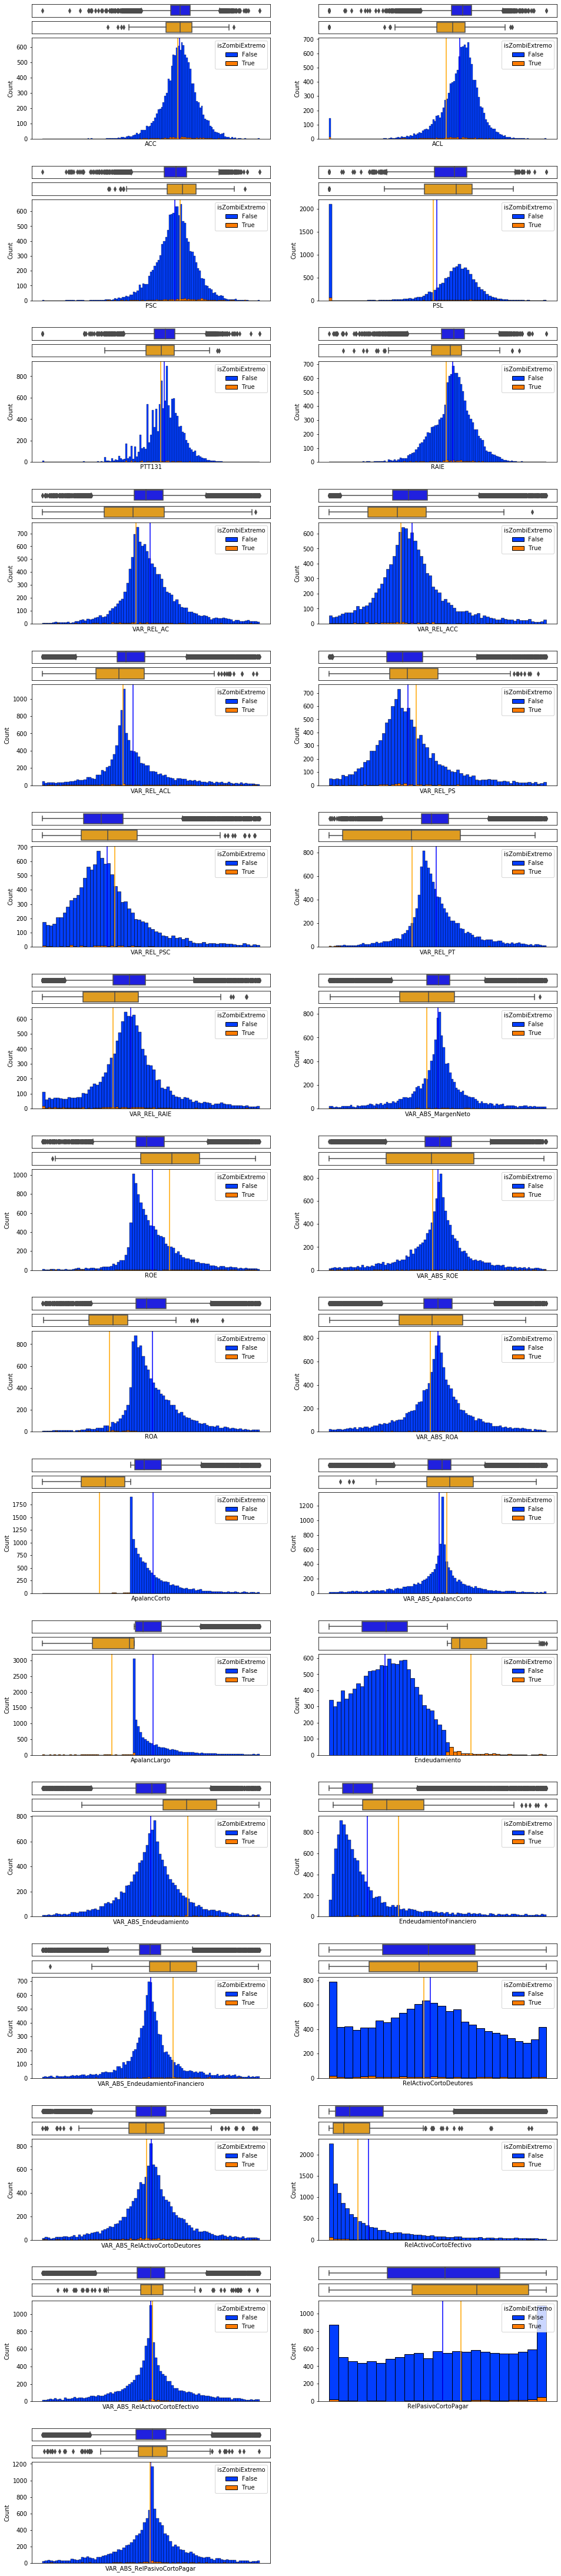

In [12]:
plot_grid(empresasZombisAgregadas, [c for c in empresasZombisAgregadas.columns.values.tolist() if c not in ['isZombiExtremo','ID','isZombiOECD'] + categoricalVars],"isZombiExtremo")

El número de instancias zombis para esta definición es demasiado bajo como para sacar conclusiones fiables. No hay suficiente variabilidad en los datos para que las distribuciones se definan en el caso zombi.

A continuación se analizan las relaciones mediante los datos básicos de empresa.

In [13]:
# Merge con los datos básicos
basicos = basicos.rename({'Id':'ID'}, axis=1)
empresasZombisBasicos = empresasZombis.merge(basicos,on="ID",how="inner")
empresasZombisBasicos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13004 entries, 0 to 13003
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   isZombiExtremo    13004 non-null  object 
 1   isZombiOECD       13004 non-null  object 
 2   ID                13004 non-null  float64
 3   Tipologia         13004 non-null  object 
 4   Sociedad          13004 non-null  object 
 5   NumEmpleadosLog   13004 non-null  float64
 6   Tamanyo           13004 non-null  object 
 7   Departamento      13004 non-null  object 
 8   Municipio         13004 non-null  object 
 9   AnyoConstitucion  13004 non-null  int64  
 10  Seccion           13004 non-null  object 
 11  Division          13004 non-null  int64  
 12  Grupo             13004 non-null  int64  
 13  Clase             13004 non-null  int64  
 14  CategoriaRural    13004 non-null  object 
dtypes: float64(2), int64(4), object(9)
memory usage: 1.6+ MB


Se empieza el análisis con una comparación de boxplots según la clase zombi para las variables numéricas (número de empleados y año de constitución).

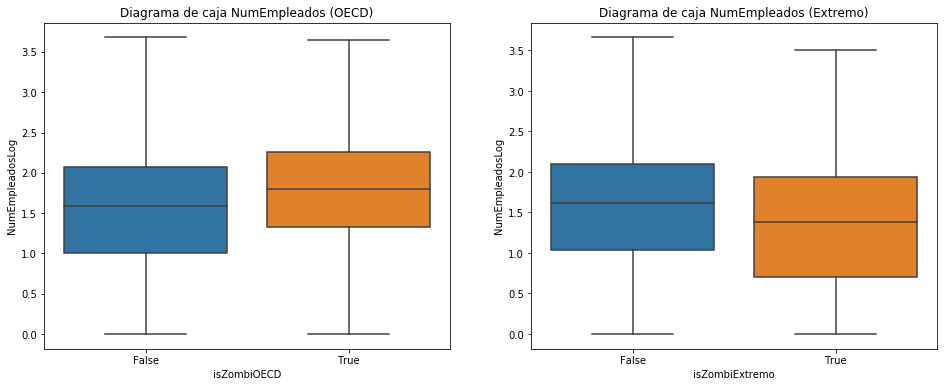

In [14]:
fig, axes = plt.subplots(1,2, figsize=(16,6))

sns.boxplot(x="isZombiOECD", y="NumEmpleadosLog", data=empresasZombisBasicos, showfliers = False, ax =axes[0])
sns.boxplot(x="isZombiExtremo", y="NumEmpleadosLog", data=empresasZombisBasicos, showfliers = False, ax =axes[1])
axes[0].set_title("Diagrama de caja NumEmpleados (OECD)")
axes[1].set_title("Diagrama de caja NumEmpleados (Extremo)")
plt.show()


Se observa una diferencia importante y es que las empresas zombis extremas tienen menor número de empleados respecto a las zombis según la OECD.

Los dos grupos difieren por poco en el número de empleados en ambas variables objetivo.

A continuación se analiza el año de constitución de la empresa:

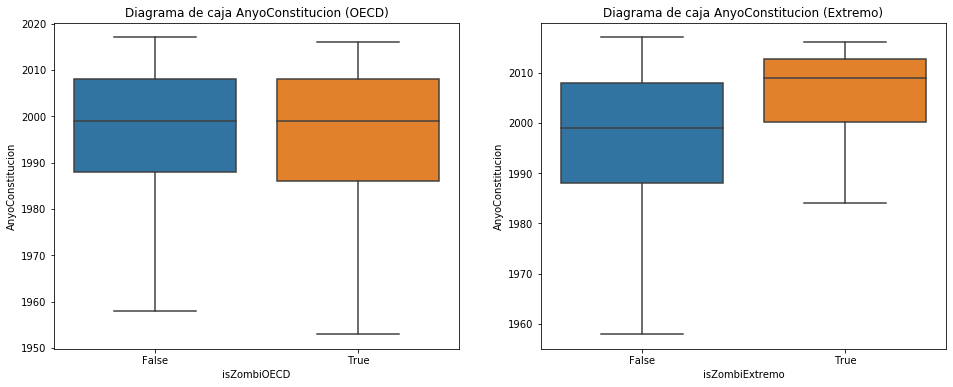

In [16]:
fig, axes = plt.subplots(1,2, figsize=(16,6))

sns.boxplot(x="isZombiOECD", y="AnyoConstitucion", data=empresasZombisBasicos, showfliers = False, ax =axes[0])
sns.boxplot(x="isZombiExtremo", y="AnyoConstitucion", data=empresasZombisBasicos, showfliers = False, ax =axes[1])
axes[0].set_title("Diagrama de caja AnyoConstitucion (OECD)")
axes[1].set_title("Diagrama de caja AnyoConstitucion (Extremo)")
plt.show()

Se observa como el anyo de constitución no es relevante para la definición de la OECD pero si que existen diferencias significativas para los zombis extremos. En todo caso, el número de instancias es tan bajo que no se pueda asegurar que esta diferencia sea casualidad para el caso zombi extremo.

Por último, se realiza un test de chi-squared de independencia entre las variables categóricas con la etiqueta zombi.

Se debe verificar que se cumpla la [asumción](https://sites.google.com/a/lakeheadu.ca/bweaver/Home/statistics/notes/chisqr_assumptions) de chi2 para tablas mayores que 2x2 

En primer lugar para la definición de la OECD:

La variable Sociedad no asume las condiciones de chi2 del 20% de expected counts
La variable Departamento no asume las condiciones de chi2 del 20% de expected counts
La variable Municipio no asume las condiciones de chi2 del 20% de expected counts
La variable Division no asume las condiciones de chi2 del 20% de expected counts
La variable Grupo no asume las condiciones de chi2 del 20% de expected counts
La variable Clase no asume las condiciones de chi2 del 20% de expected counts
No han rechazado la hipótesis nula: ['Tipologia' 'Sociedad' 'Departamento' 'Municipio' 'Division' 'Grupo'
 'Clase']


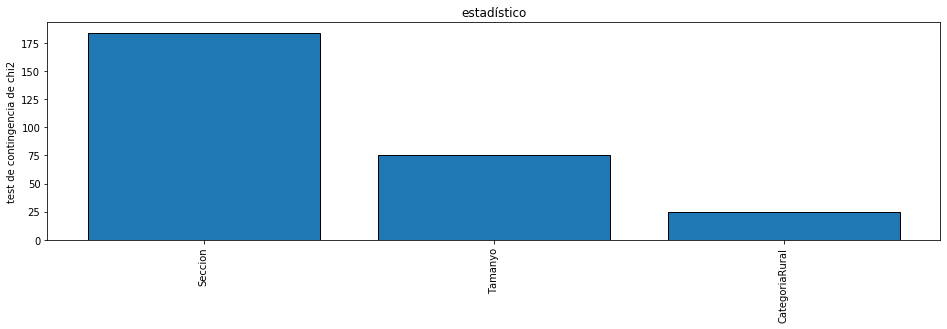

In [17]:
def find_p_value(df, column, target):
    crosstab = pd.crosstab(df[column], df[target])
    stat, p, dof, expected = stats.chi2_contingency(crosstab)
    cntexpected=expected[expected<5].size
    if (expected.size * 0.2 < cntexpected):
        print("La variable {0} no asume las condiciones de chi2 del 20% de expected counts".format(column))
        return {'stat':0,'p-value':2,'column':column}
    cntexpectedind = expected[expected<1].size
    if (cntexpectedind > 0):
        print("La variable {0} no asume las condiciones de chi2 por tener más de 1 variable con expected < 1".format(column))
        return {'stat':0,'p-value':2,'column':column}
        
    return {'stat':stat,'p-value':p,'column':column}

def find_p_values(df, columns, target_column):
    return [find_p_value(df, column, target_column) for column in columns]

plotShowStatTest(empresasZombisBasicos, ['ID','isZombiExtremo','isZombiOECD','AnyoConstitucion','NumEmpleadosLog'], 'isZombiOECD', find_p_values, "estadístico", "test de contingencia de chi2")

Y en segundo lugar para la definición extrema:

La variable Tipologia no asume las condiciones de chi2 del 20% de expected counts
La variable Sociedad no asume las condiciones de chi2 del 20% de expected counts
La variable Departamento no asume las condiciones de chi2 del 20% de expected counts
La variable Municipio no asume las condiciones de chi2 del 20% de expected counts
La variable Seccion no asume las condiciones de chi2 del 20% de expected counts
La variable Division no asume las condiciones de chi2 del 20% de expected counts
La variable Grupo no asume las condiciones de chi2 del 20% de expected counts
La variable Clase no asume las condiciones de chi2 del 20% de expected counts
La variable CategoriaRural no asume las condiciones de chi2 del 20% de expected counts
No han rechazado la hipótesis nula: ['Tipologia' 'Sociedad' 'Departamento' 'Municipio' 'Seccion' 'Division'
 'Grupo' 'Clase' 'CategoriaRural']


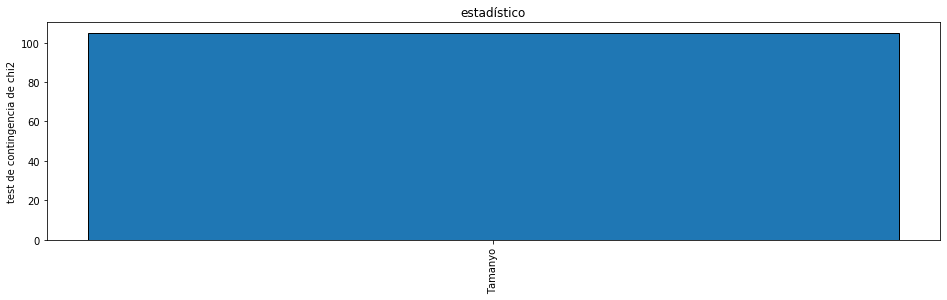

In [18]:
plotShowStatTest(empresasZombisBasicos, ['ID','isZombiExtremo','isZombiOECD','AnyoConstitucion','NumEmpleadosLog'], 'isZombiExtremo', find_p_values, "estadístico", "test de contingencia de chi2")

Muchas de las variables no tienen las condiciones necesarias para poder realizar el test chi-squared. Esto se debe a las bajas expected frequencies de las tablas de contingencia. Algunas clases no tienen suficiente representación de zombis y por lo tanto, no se puede realizar el test.

Entre las variables que sí que pasan el test, destacan la sección, el tamaño de la empresa y la categoria rural de la empresa.

Cabe destacar que la variable de zombi extremo solo puede realizar el test en el tamaño de la empresa. Todas las otras variables no pasan las condiciones necesarias.

El problema de las expected counts se puede solucionar mediante la agregación de las categorías de las variables. Se consideran las siguientes agregaciones:

1. Para grupo, división, clase... no se considera agregar estas variables, ya que ya existe un nivel superior de agregación que ha podido realizar el test de independencia: sección. Estas variables serán eliminadas.
2. Para las otras variables, es necesario inspeccionar los conteos de categorías. Se agruparán aquellas categorías menos representativas para que pasen la prueba de los expected frequencies.

In [19]:
# Conteo de tipologia
print(empresasZombisBasicos.Tipologia.value_counts())
print("")
print("Conteo de zombis (OECD) fuera de sociedad comercial/industrial:")
empresasZombisBasicos[empresasZombisBasicos['Tipologia'] != 'SOCIEDAD COMERCIAL/INDUSTRIAL']['isZombiOECD'].value_counts()

SOCIEDAD COMERCIAL/INDUSTRIAL    12572
ENTIDAD EXTRANJERA                 229
ENTIDAD SIN ANIMO DE LUCRO         111
EMPRESARIO INDIVIDUAL               83
SOCIEDAD NO COMERCIAL                9
Name: Tipologia, dtype: int64

Conteo de zombis (OECD) fuera de sociedad comercial/industrial:


False    373
True      59
Name: isZombiOECD, dtype: int64

La tipología apenas tiene representación zombi fuera de las sociedades comerciales/industriales, por lo que esta variable se puede omitir directamente, no tiene utilidad realizar agregaciones.

Respecto a la sociedad, sí que se pueden juntar varias de las categorías menos representativas en el dataset.

In [20]:
# Conteo de sociedad
print(empresasZombisBasicos.Sociedad.value_counts())
print("")
print("Conteo de zombis (OECD) fuera de SAS, SA y SL")
empresasZombisBasicos[(empresasZombisBasicos['Sociedad'] != 'SAS') & (empresasZombisBasicos['Sociedad'] != 'SA')]['isZombiOECD'].value_counts()

SAS     8304
SA      2895
SL      1046
SE       229
SCS      180
SCA      135
ESAL     104
PN        67
OES       17
EU        15
SCV        9
ASO        1
AL         1
SH         1
Name: Sociedad, dtype: int64

Conteo de zombis (OECD) fuera de SAS, SA y SL


False    1646
True      159
Name: isZombiOECD, dtype: int64

Se pueden juntar todas las categorías a partir de SL hacia abajo en una de sola, que se denominará "SociedadOtros".

In [21]:
empresasZombisBasicos.loc[(empresasZombisBasicos['Sociedad'] != 'SAS') & (empresasZombisBasicos['Sociedad'] != 'SA'),'Sociedad'] = 'SociedadOtros'
print(empresasZombisBasicos.Sociedad.value_counts())

SAS              8304
SA               2895
SociedadOtros    1805
Name: Sociedad, dtype: int64


Para los departamentos se propone un mecanismo similar. Agrupar aquellos departamentos con baja representación en un solo grupo.

In [22]:
# Conteo de departamentos
departamentosConservar = ['bogota','antioquia','valle','cundinamarca','atlantico','santander','bolivar','risaralda','norte santander','caldas','magdalena','meta','tolima']
print(empresasZombisBasicos.Departamento.value_counts())
print("")
print("Conteo de zombis (OECD) a partir de tolima ")
empresasZombisBasicos[~empresasZombisBasicos['Departamento'].isin(departamentosConservar)]['isZombiOECD'].value_counts()

bogota             5974
antioquia          2163
valle              1090
cundinamarca        866
atlantico           670
santander           477
bolivar             267
risaralda           219
norte santander     147
caldas              140
magdalena           136
meta                107
tolima              103
huila                83
quindio              83
boyaca               79
cauca                76
cordoba              72
narino               68
cesar                58
casanare             46
sucre                31
caqueta              19
la guajira           10
putumayo              7
amazonas              4
choco                 4
arauca                3
vichada               2
Name: Departamento, dtype: int64

Conteo de zombis (OECD) a partir de tolima 


False    587
True      58
Name: isZombiOECD, dtype: int64

A partir de tolima se juntan todos los otros departamentos en la categoría "OtrosDepartamentos"

In [23]:
departamentosConservar = ['bogota','antioquia','valle','cundinamarca','atlantico','santander','bolivar','risaralda','norte santander','caldas','magdalena','meta','tolima']
empresasZombisBasicos.loc[~empresasZombisBasicos['Departamento'].isin(departamentosConservar),'Departamento'] = 'OtrosDepartamentos'
empresasZombisBasicos['Departamento'].value_counts()

bogota                5974
antioquia             2163
valle                 1090
cundinamarca           866
atlantico              670
OtrosDepartamentos     645
santander              477
bolivar                267
risaralda              219
norte santander        147
caldas                 140
magdalena              136
meta                   107
tolima                 103
Name: Departamento, dtype: int64

Se vuelve a pasar el test chi2 sobre las nuevas agregaciones.

La variable Municipio no asume las condiciones de chi2 del 20% de expected counts
La variable Division no asume las condiciones de chi2 del 20% de expected counts
La variable Grupo no asume las condiciones de chi2 del 20% de expected counts
La variable Clase no asume las condiciones de chi2 del 20% de expected counts
No han rechazado la hipótesis nula: ['Tipologia' 'Municipio' 'Division' 'Grupo' 'Clase']


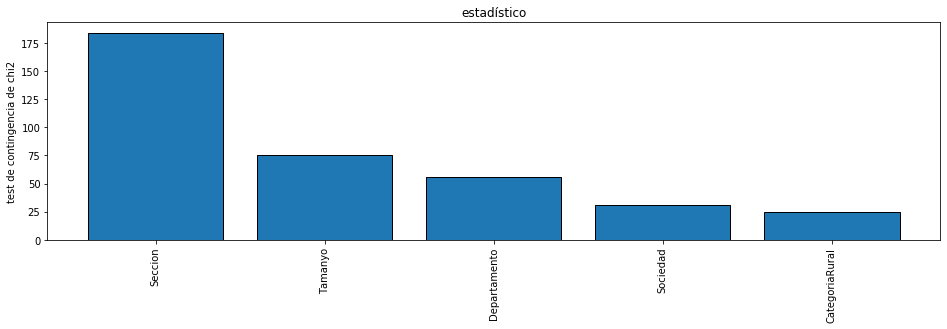

In [24]:
plotShowStatTest(empresasZombisBasicos, ['ID','isZombiExtremo','isZombiOECD','AnyoConstitucion','NumEmpleadosLog'], 'isZombiOECD', find_p_values, "estadístico", "test de contingencia de chi2")

Esta vez, departamento y sociedad pasan el test y resultan tener relación con la zombicidad según la OECD. 

En definitiva, todas las pruebas hasta el momento se decantan por favorecer la definición de la OECD por delante de la de zombi extremo. Los motivos son:

* Una mayor cantidad y mayor calidad de variables financieras que superan la prueba de kruskal para la definición de la OECD.
* También se aplica lo mismo para las variables categóricas y la prueba chi-squared.
* La definición de la OECD tiene muchas más instancias etiquetadas como zombis en el dataset, lo que aporta mayor variabilidad y robustez para los algoritmos de aprendizaje automático.

Por lo tanto, se prescinde de la variable de zombi extremo y se trabaja únicamente con la de la OECD.

Por último, se seleccionan las variables categóricas que se han extraído de los ejercicios

No han rechazado la hipótesis nula: []


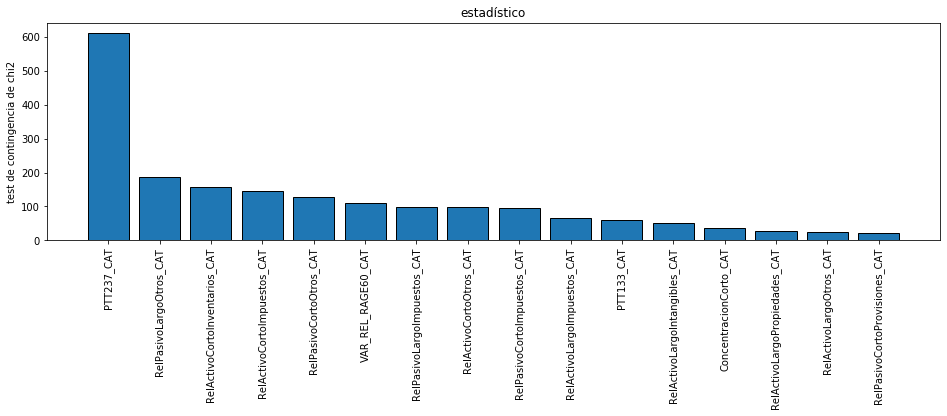

In [25]:
# Merge final del dataset
EZ = empresasZombisBasicos.merge(ejerciciosAgregados, on="ID", how="inner")
# Ver las variables categóricas que pasan el test chi2
plotShowStatTestColumns(EZ, [v for v in EZ.columns.tolist() if v.endswith("_CAT")], 'isZombiOECD', find_p_values, "estadístico", "test de contingencia de chi2")

Todas las variables parecen tener relación con la zombicidad según la OECD.


Por último, puede resultar interesante observar los gráficos de barra apilados para las variables categóricas. Estas visualiaciones proyectan la proporción zombi de cada categoría de datos en una barra, pudiendo comparar las distinas categorías a la vez.

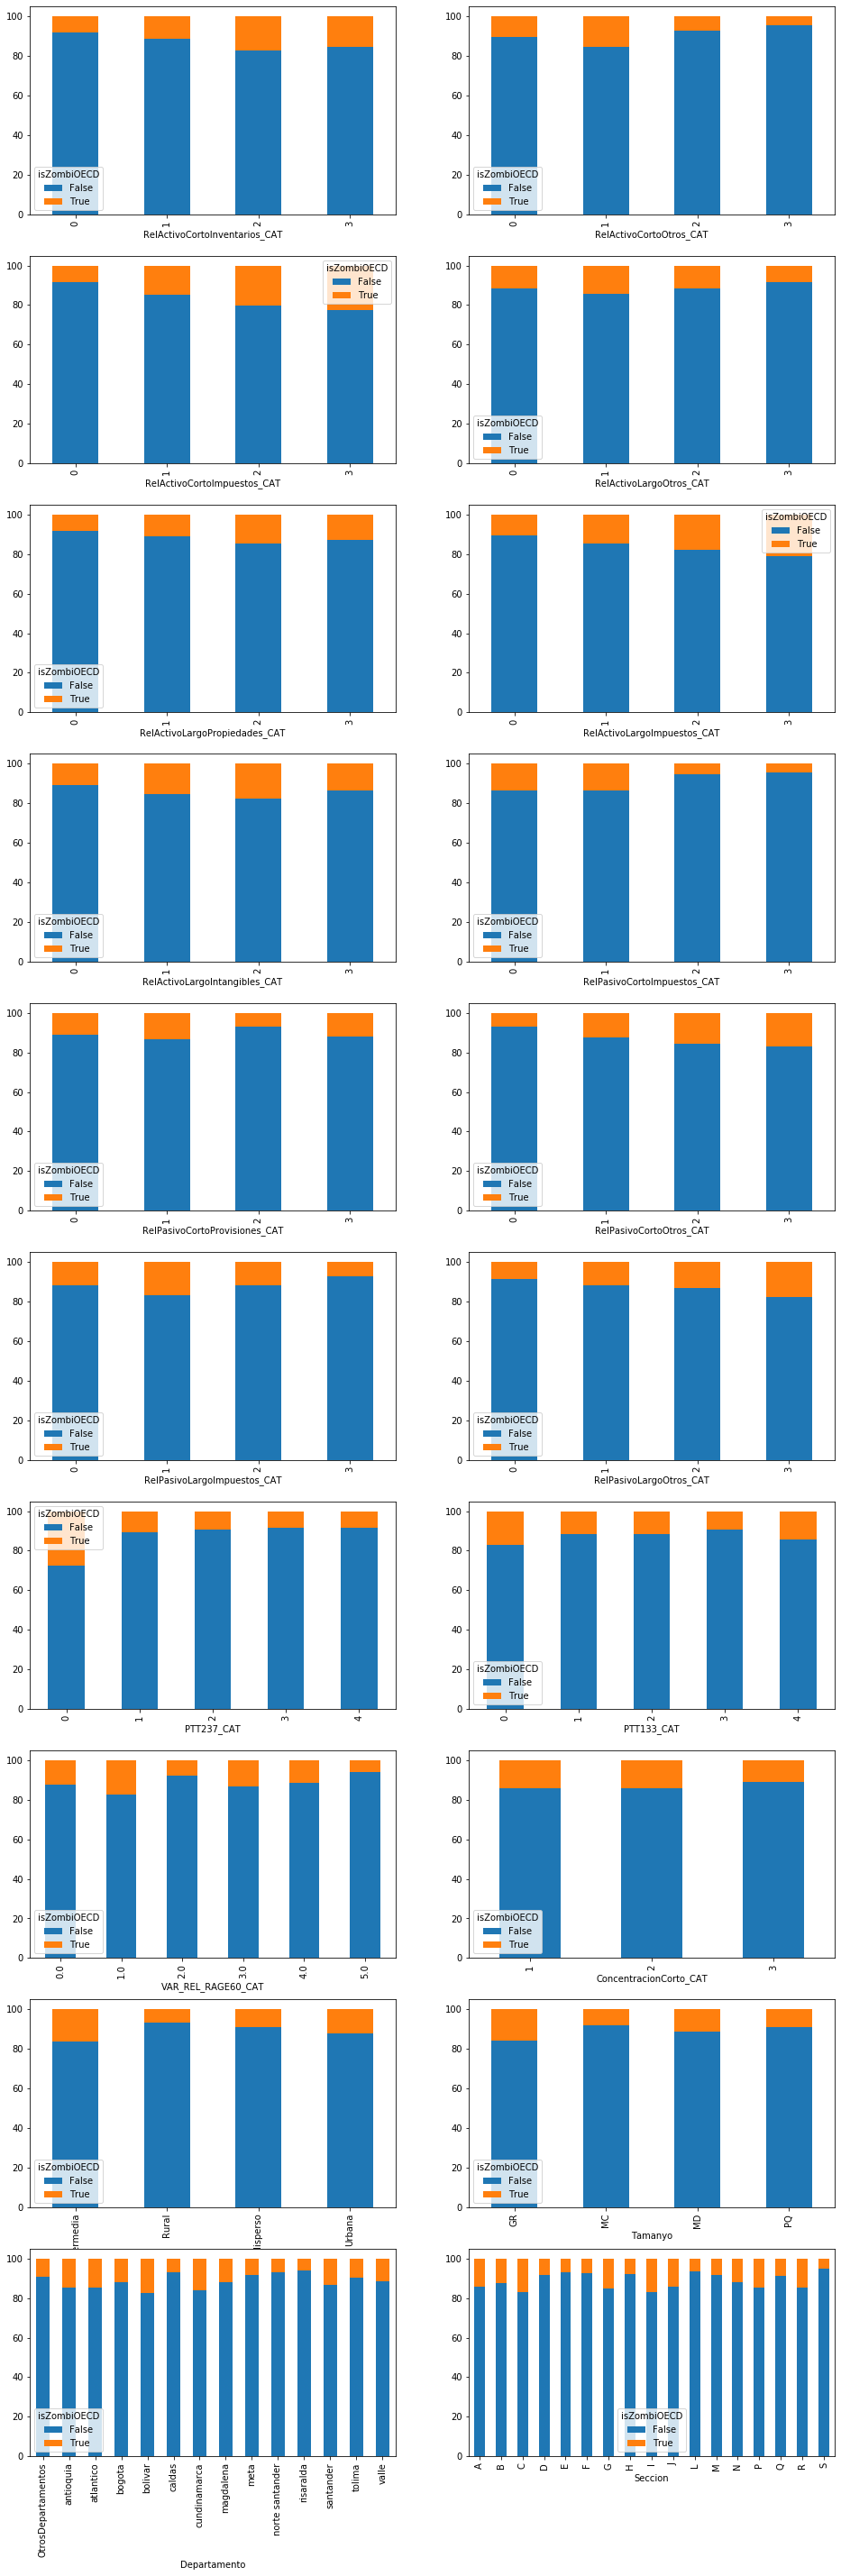

In [34]:
# Grafico de barras apilado
def stackedBarPlot(df, column1, column2, ax):
    cross = pd.crosstab(df[column1], df[column2], margins = False)
    applied = cross.apply(lambda x: x*100/sum(x), axis=1)
    applied.plot(kind="bar", stacked=True, ax=ax)
    
# Graficos de barras apilados
def internal_stackedBarPlots(df, variables, target):
    numCols = 2
    numRows = math.ceil(len(variables) / 2)
    figSize = numRows * 5
    # Construir las visualizaciones con los histogramas de las principales variables fiscales
    fig, axes = plt.subplots(numRows,numCols, figsize=(16,figSize))
    for i, v in enumerate(variables):
        row = int(i / numCols)
        col = i % numCols
        stackedBarPlot(df, v, target, axes[row][col])
        
    if (len(variables) < numCols * numRows):
        axes[numRows-1,numCols-1].axis('off')
        
    plt.show()
    
    
ordinalVars = ['CategoriaRural','Tamanyo','Departamento','Seccion']
internal_stackedBarPlots(EZ,[v for v in EZ.columns.tolist() if v.endswith('_CAT')] + ordinalVars,'isZombiOECD') 

Se observan varias diferencias significativas entre las proporciones. La más acentuada es la del patrimonio, dónde las empresas con patrimonio negativo (0), tienden a presentar más zombis.

Respecto a los departamentos, algunos como bolívar, Antioquia, Cundinamarca y Santander presentan más concentración zombi que las demás.

Respecto a las secciones, por ejemplo, la manufacturera (C), el alojamiento (I) y el comercio al por menor (G) presentan un alto nivel de zombicidad. Otros como la construcción (F) o el inmobiliario (L) no presentan tan altos niveles.

## Selección y corrección de errores
Una vez se ha decidido la etiqueta a utilizar, se deben eliminar y corregir las variables que venían de herencia, así como las no redundantes que se hayan detectado en el análisis previo.

Las variables hasta el momento son:

In [30]:
EZ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13004 entries, 0 to 13003
Data columns (total 62 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   isZombiExtremo                   13004 non-null  object 
 1   isZombiOECD                      13004 non-null  object 
 2   ID                               13004 non-null  float64
 3   Tipologia                        13004 non-null  object 
 4   Sociedad                         13004 non-null  object 
 5   NumEmpleadosLog                  13004 non-null  float64
 6   Tamanyo                          13004 non-null  object 
 7   Departamento                     13004 non-null  object 
 8   Municipio                        13004 non-null  object 
 9   AnyoConstitucion                 13004 non-null  int64  
 10  Seccion                          13004 non-null  object 
 11  Division                         13004 non-null  int64  
 12  Grupo             

Las variables que se deben eliminar y su motivo son:

1. isZombiExtremo: etiquetación descartada.
2. Tipologia: no pasa el test chi2 y no relevante.
3. Municipio: no pasa el test chi2. Demasiados municipios y ya se cuenta con el departamento como nivel superior de agregación.
4. AnyoConstitución: Distribuciones muy similares entre grupos.
5. Grupo, Clase, División: se conserva únicamente la sección de la empresa. Se debe seleccionar únicamente una de estas variables ya que son completamente dependientes. Se decide seleccionar la más granular para que las empresas zombis tengan representación entre grupos.
6. ROE, ROA: por tener bias en la definición. También sus variaciones.
7. Variaciones relativas en PS, PSC,
8. Variaciones absolutas en RelActivoCortoEfectivo, RelPasivoCortoPagar.
9. RelPasivoCortoPagar tampoco pasa el test. 


Al final, se conservan las variables:

In [31]:
variablesRent = ['ROE','ROA']
variablesEliminar = ['isZombiExtremo','Tipologia','Municipio','AnyoConstitucion','Grupo','Clase','Division',\
                     'VAR_ABS_MargenNeto','VAR_ABS_ROE','VAR_ABS_ROA',
                     'VAR_REL_PS','VAR_REL_PSC',\
                     'VAR_ABS_RelActivoCortoEfectivo','VAR_ABS_RelPasivoCortoPagar',\
                     'RelPasivoCortoPagar']

variablesEliminar = variablesEliminar + variablesRent
EZSeleccion = EZ.copy(deep=True)
EZSeleccion = EZSeleccion.drop(variablesEliminar,axis=1)

El siguiente paso que se propone es un **ranking de características más relacionadas con la variable objetivo**. Esto se puede conseguir mediante el uso de los árboles de decisión.

Para ello, primero se deben preparar los datos para el algoritmo. El primer paso es convertir a variables ordinales aquellas categóricas que presenten una relación de orden.

Estas variables son la ruralidad y el tamaño de la empresa.

In [32]:
# De menor a mayor tamaño
mapperTamanyo = {'MC':0,'PQ':1,'MD':2,'GR':3}
# De menor a mayor categoría rural
mapperRural = {'Rural disperso':0,'Rural':1,'Intermedia':2,'Urbana':3}

ordinalVars = ['TamanyoInt','CategoriaRuralInt']

# Crear las nuevas variables ordinales
temp = pd.concat((EZSeleccion,EZSeleccion['Tamanyo'].map(mapperTamanyo).rename("TamanyoInt")),1)
temp = pd.concat((temp,EZSeleccion['CategoriaRural'].map(mapperRural).rename("CategoriaRuralInt")),1)
ezOrdinal = temp
print("Valores de categoria rural después de transformar a numérico:")
print(ezOrdinal.CategoriaRuralInt.value_counts())
print("Valores de tamaño de empresa después de transformar a numérico:")
print(ezOrdinal.TamanyoInt.value_counts())

Valores de categoria rural después de transformar a numérico:
3    11370
2     1491
1      121
0       22
Name: CategoriaRuralInt, dtype: int64
Valores de tamaño de empresa después de transformar a numérico:
2    7048
3    4337
1    1468
0     151
Name: TamanyoInt, dtype: int64


Adicionalmente, los árboles de decisión tampoco pueden trabajar con variables categóricas no ordinales. Estas se tienen que transformar a su representación "dummy". Esta transformación proyecta cada categoría de datos a una nueva columna en el dataset que toma los valores {0,1} según la fila que tenga esa categoría.

In [35]:
# Se crean las variables dummies de las categóricas
dummyVars = ['Sociedad','Departamento','Seccion']
# Guardar las variables dummies en un array para filtrajes posteriores
createdDummyVars = []
temp = ezOrdinal
for var in dummyVars:
    dummy = pd.get_dummies(temp[var])
    createdDummyVars = createdDummyVars + dummy.columns.values.tolist()
    temp = pd.concat((temp, dummy),1)

# Eliminar las variables de origen
ezConcated = temp.drop(['Tamanyo','Departamento','Seccion','CategoriaRural','Sociedad'], axis=1)
ezConcated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13004 entries, 0 to 13003
Data columns (total 76 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   isZombiOECD                      13004 non-null  object 
 1   ID                               13004 non-null  float64
 2   NumEmpleadosLog                  13004 non-null  float64
 3   ACC                              13004 non-null  float64
 4   ACL                              13004 non-null  float64
 5   PSC                              13004 non-null  float64
 6   PSL                              13004 non-null  float64
 7   PTT131                           13004 non-null  float64
 8   RAIE                             13004 non-null  float64
 9   VAR_REL_AC                       12516 non-null  float64
 10  VAR_REL_ACC                      12321 non-null  float64
 11  VAR_REL_ACL                      12010 non-null  float64
 12  VAR_REL_PT        

Una vez se han transformado los datos ya se puede aplicar la selección de atributos mediante **ExtraTrees**. Estos árboles son un método ensamble de aprendizaje automático similar a los random forest. Su intención es crear un rango de importancias entre las variables independientes y objetivo para determinar cuáles obtienen un mejor índice de GINI.

Es decir, aquellas con mayor importancia son las que mejor separan el dataset según la variable objetivo.

In [36]:
# Es necesario prescindir de los missings para que el algoritmo suceda correctamente
ezNoNA = ezConcated.dropna()
# Crear la variable target y las independientes
target = ezNoNA.isZombiOECD.map({True:1,False:0})
selection = ezNoNA.drop(['isZombiOECD'], axis=1)
selection = selection.set_index('ID')

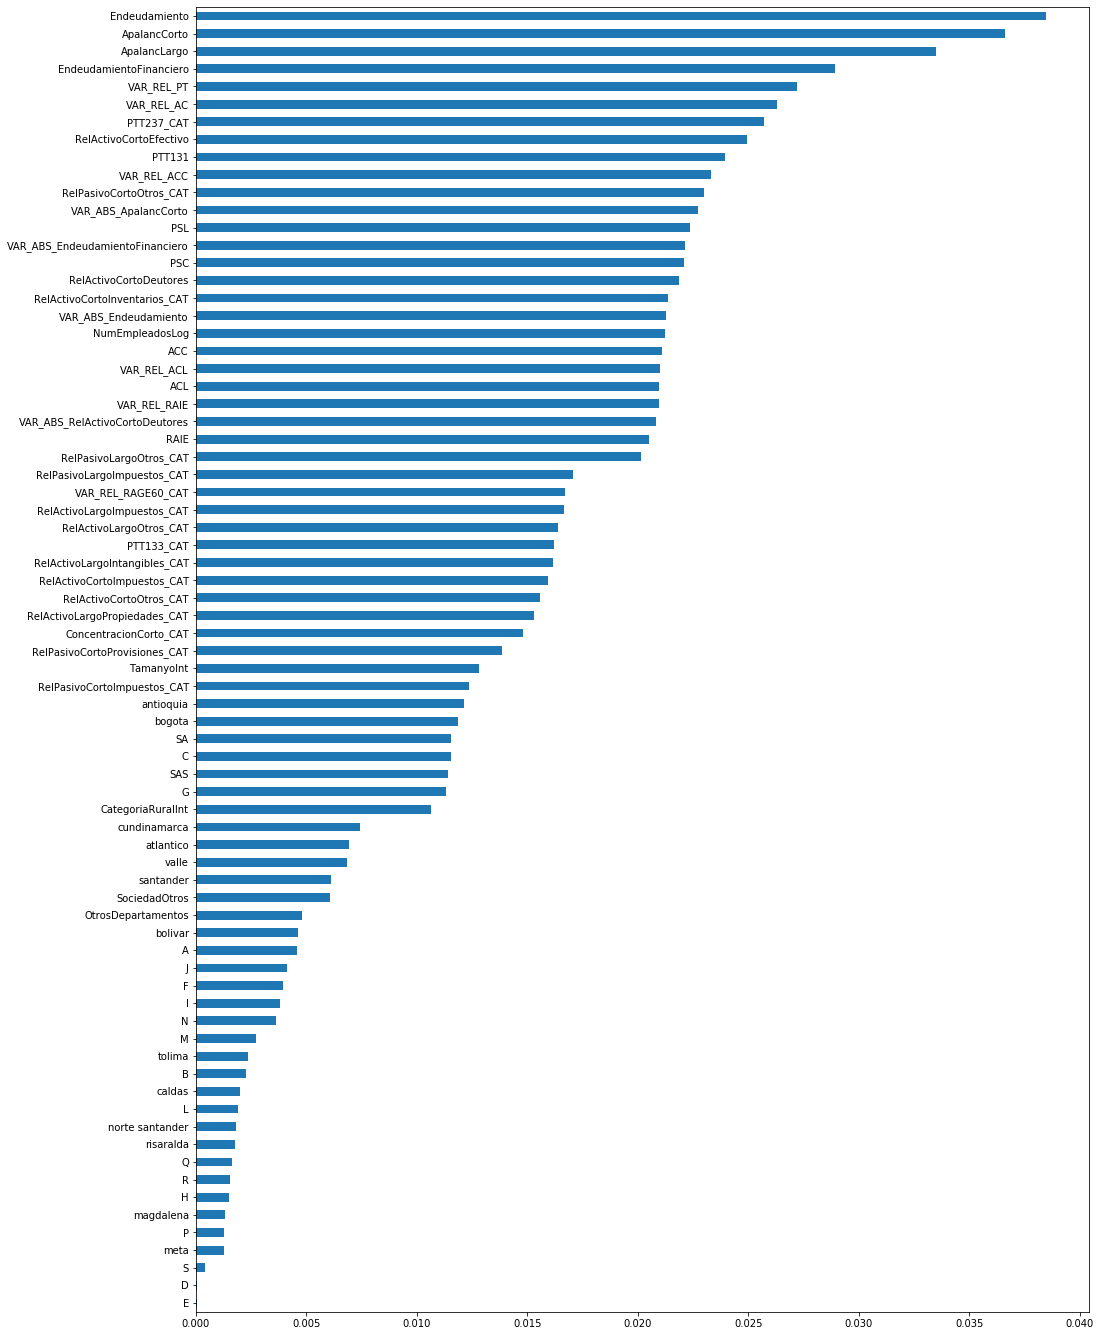

In [37]:
# Creación del ranking de características relevantes
model = ExtraTreesClassifier(n_estimators=500)
model.fit(selection,target)
fig = plt.figure(figsize=(16,24))
feat_importances = pd.Series(model.feature_importances_, index=selection.columns)
feat_importances = feat_importances.sort_values()
feat_importances.plot(kind='barh')
plt.show()

Se observa que la importancia de las variables es relativamente baja respecto a la target. Esto puede ser por varios motivos:

1. Ninguna de las variables es demasiado relevante para clasificar correctamente la variable objetivo.
2. Quizá exista una función no representable por los árboles de decisión que oculte la verdadera fórmula para determinar si una empresa es zombi o no.

Además, es notable mencionar que la importancia de las variables de los datos básicos de las empresas es completamente menor que la de las variables financieras.

Es decir, que los departamentos, las secciones, la tipología de la empresa... tienen muy poca importancia comparada con todos los datos financieros y sus transformaciones que se hayan obtenido anteriormente.

Aun así, no se considera prescindir de los datos básicos, ya que su función descriptiva es demasiado grande como para omitirlos.

Por último, se decide qué hacer con los valores perdidos. Estos representan mayoritariamente empresas sin un dato financiero informado para algún ejercicio, por lo que no se han podido calcular los ratios ni las variaciones.

Se miran cuantas filas se sacrifican si se eliminan los valores nulos directamente:

In [38]:
print("Filas resultantes si se eliminan las filas con valores perdidos: {0}".format(len(ezConcated.dropna())))

Filas resultantes si se eliminan las filas con valores perdidos: 7440


Resulta bastante penalizador, ya que se pierde la mitad del dataset. Aunque no parezca que falten tantos datos mirando los missings de las columnas, hay que recordar que tienen porqué ser las mismas empresas en cada columna.

Se propone imputar cada valor perdido mediante KNN. Se normalizan los valores antes de realizar la imputación (mediante MinMax) para evitar bias de proximidad entre los vecinos.

In [40]:
# Es necesario escalar las variables para evitar bias de distancias
scaler = MinMaxScaler()
features = ezConcated.drop(['isZombiOECD'], axis=1)
target = ezConcated.isZombiOECD

# Realizar el escalado y la imputacion
trans = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
imputer = KNNImputer()
imputed = imputer.fit_transform(trans)
reverse = scaler.inverse_transform(imputed)
ezNoMissings = pd.concat((pd.DataFrame(reverse, columns=features.columns),target),axis=1)
ezNoMissings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13004 entries, 0 to 13003
Data columns (total 76 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               13004 non-null  float64
 1   NumEmpleadosLog                  13004 non-null  float64
 2   ACC                              13004 non-null  float64
 3   ACL                              13004 non-null  float64
 4   PSC                              13004 non-null  float64
 5   PSL                              13004 non-null  float64
 6   PTT131                           13004 non-null  float64
 7   RAIE                             13004 non-null  float64
 8   VAR_REL_AC                       13004 non-null  float64
 9   VAR_REL_ACC                      13004 non-null  float64
 10  VAR_REL_ACL                      13004 non-null  float64
 11  VAR_REL_PT                       13004 non-null  float64
 12  VAR_REL_RAIE      

Se guardan los datos limpios en un fichero en el disco.

In [41]:
ezNoMissings.to_csv('data/EmpresasZombisClean.csv', index=False, sep=";")